In [1]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:
class Generator(nn.Module):
  def __init__(self,img_shape,latent_dim):
    super(Generator, self).__init__()

    def block(in_features, out_features, normalize=True):
      layers = [nn.Linear(in_features, out_features)]
      if normalize:
        layers.append(nn.BatchNorm1d(out_features, 0.8))
      layers.append(nn.LeakyReLU(0.2, inplace=True))
      return layers
    self.model = nn.Sequential(*block(in_features=latent_dim,out_features=256,normalize=False),
                               nn.Linear(in_features=256,out_features=int(np.prod(img_shape))),
                               nn.Tanh())


  def forward(self,img_shape,z):
    img = self.model(z)
    img = img.view(img.shape[0], *img_shape)
    return img


In [3]:
class Critic(nn.Module):
  def __init__(self,img_shape):
    super(Critic, self).__init__()

    self.model = nn.Sequential(nn.Linear(in_features=int(np.prod(img_shape)),out_features=256),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(in_features=256,out_features=1),
                               )
  def forward(self,img):
    img_flat = img.view(img.shape[0], -1)
    validity = self.model(img_flat)
    return validity


In [4]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm

plt.ion()

def weigths_init_normal(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    torch.nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find("BatchNorm2d") != -1:
    torch.nn.init.normal_(m.weight.data,1.0,0.02)
    torch.nn.init.constant_(m.bias.data,0.0)


def to_img(x):
  x= x.clamp(0,1)
  return x

def visualise_output(images,x,y):
  with torch.no_grad():
    images = images.cpu()
    images = to_img(images)
    np_imagegrid = make_grid(images,x,y).numpy()
    figure(figsize=(10,10))
    plt.imshow(np.transpose(np_imagegrid, (1,2,0)))
    plt.show()

In [5]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable
import torch

plt.ion()
from IPython.display import clear_output

In [6]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [7]:
class Hyperparameters(object):
  def __init__(self,**kwargs):
    self.__dict__.update(kwargs)

hp = Hyperparameters(n_epochs=1000,
                     batch_size=128,
                     lr=0.0001,
                     n_cpu=8,
                     latent_dim=100,
                     img_size=32,
                     channels=1,
                     n_critic=25,
                     clip_value=0.005,
                     sample_interval=400)



In [8]:
train_dataloader= torch.utils.data.DataLoader(
    datasets.FashionMNIST("/content/",
                          train=True,
                          download=True,
                          transform=transforms.Compose([
                               transforms.Resize(hp.img_size),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5],[0.5])])),
                          batch_size=hp.batch_size,shuffle=True)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.57MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 138kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.24MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 6.94MB/s]


In [9]:
img_shape = (hp.channels,hp.img_size,hp.img_size)

generator = Generator(img_shape,hp.latent_dim)
critic = Critic(img_shape)

if cuda:
  generator.cuda()
  critic.cuda()

optimizer_G = torch.optim.RMSprop(generator.parameters(),lr=hp.lr)
optimizer_D = torch.optim.RMSprop(critic.parameters(),lr=hp.lr)

generator.apply(weigths_init_normal)
critic.apply(weigths_init_normal)

def train():
    for epoch in range(hp.n_epochs):
        for i, (imgs, _) in enumerate(train_dataloader):

            valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

            real_imgs = Variable(imgs.type(Tensor))
            optimizer_G.zero_grad()


            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], hp.latent_dim))))
            fake_imgs = generator(img_shape, z).detach()

            d_loss = -torch.mean(critic(real_imgs)) + torch.mean(critic(fake_imgs))
            d_loss.backward()
            optimizer_D.step()

            for p in critic.parameters():
                p.data.clamp_(-hp.clip_value, hp.clip_value)

            if i % hp.n_critic == 0:
                optimizer_G.zero_grad()
                fake_images_from_generator = generator(img_shape, z)
                g_loss = -torch.mean(critic(fake_images_from_generator))
                g_loss.backward()
                optimizer_G.step()

            batches_done = epoch * len(train_dataloader) + i

            if batches_done % hp.sample_interval == 0:
                clear_output()
                print(f"[Epoch:{epoch}/{hp.n_epochs}]  [It:{i}]  [DLoss:{d_loss.item()}]  [GLoss:{g_loss.item()}]")
                visualise_output(fake_images_from_generator.data[:50], 10, 10)

[Epoch:999/1000]  [It:269]  [DLoss:0.006485939025878906]  [GLoss:-0.4284302890300751]


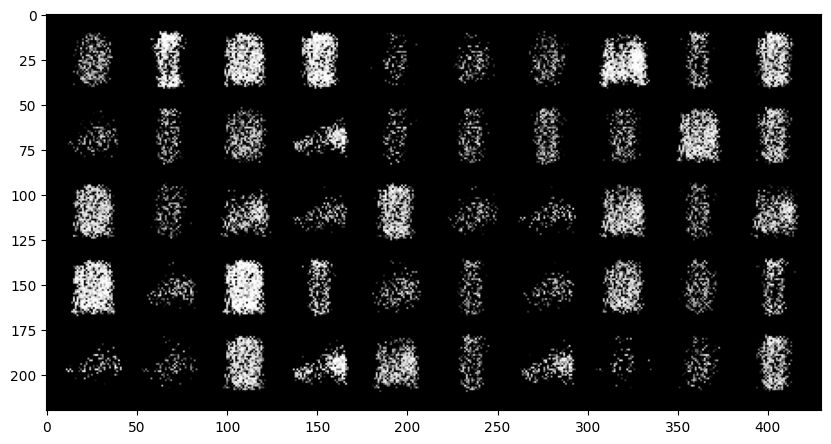

In [10]:
train()

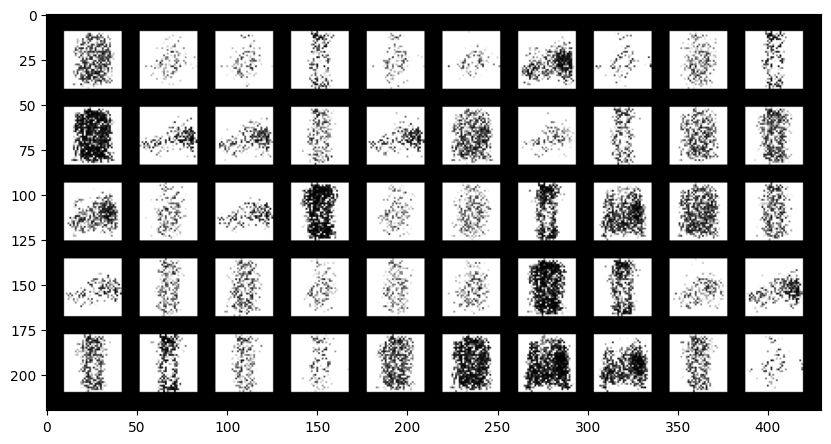

In [16]:
imgs, _ = next(iter(train_dataloader))
z = Variable(Tensor(np.random.normal(0,1,(imgs.shape[0],hp.latent_dim))))
fake_imgs = generator(img_shape,z).detach()
fake_imgages_from_generator = -1*(fake_imgs-1)
visualise_output(fake_imgages_from_generator.data[:50],10,10)